In [24]:
import pickle
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scienceplots
from tqdm import tqdm
from seaborn import displot, histplot, relplot
plt.style.use(['nature'])
from shapely.geometry import LineString
from conflict import ConflictLyft

In [25]:
# first junction
with open('./lyft_avhv_conflict_j1.pkl', 'rb') as file:
    lyft_avhv_conflict_list1 = pickle.load(file)

with open('./lyft_hvhv_conflict_j1.pkl', 'rb') as file:
    lyft_hvhv_conflict_list1 = pickle.load(file)

lyft_conflict_list1 = lyft_avhv_conflict_list1 + lyft_hvhv_conflict_list1

# second junction
with open('./lyft_avhv_conflict_j2.pkl', 'rb') as file:
    lyft_avhv_conflict_list2 = pickle.load(file)

with open('./lyft_hvhv_conflict_j2.pkl', 'rb') as file:
    lyft_hvhv_conflict_list2 = pickle.load(file)

lyft_conflict_list2 = lyft_avhv_conflict_list2 + lyft_hvhv_conflict_list2

# report sample size
len(lyft_conflict_list1), len(lyft_conflict_list2)

(859, 886)

In [36]:
# convert the type to latest conflict object
conflict_list1 = list()
for c_index, c in enumerate(lyft_conflict_list1):
    # print(c_index)
    conflict_list1.append(ConflictLyft(
        leader_id=c.first_id,
        follower_id=c.second_id,
        leader_time_at_conflict=c.first_time_at_conflict,
        follower_time_at_conflict=c.second_time_at_conflict,
        leader_is_av=c.is_first_AV,
        follower_is_av=c.is_second_AV,
        PET=c.PET,
        conflict_type=c.category.upper(),
        leader_traj=c.first_trajectory.xy[1:-1,:],
        follower_traj=c.second_trajectory.xy[1:-1,:],
        leader_traj_timestamp=c.first_trajectory.t[1:-1],
        follower_traj_timestamp=c.second_trajectory.t[1:-1],
        leader_traj_speed=c.first_trajectory.smoothed_v,
        follower_traj_speed=c.second_trajectory.smoothed_v,
        junction_id=1,
    ))
assert len(conflict_list1) == len(lyft_conflict_list1)

conflict_list2 = list()
for c_index, c in enumerate(lyft_conflict_list2):
    # print(c_index)
    conflict_list2.append(ConflictLyft(
        leader_id=c.first_id,
        follower_id=c.second_id,
        leader_time_at_conflict=c.first_time_at_conflict,
        follower_time_at_conflict=c.second_time_at_conflict,
        leader_is_av=c.is_first_AV,
        follower_is_av=c.is_second_AV,
        PET=c.PET,
        conflict_type=c.category.upper(),
        leader_traj=c.first_trajectory.xy[1:-1,:],
        follower_traj=c.second_trajectory.xy[1:-1,:],
        leader_traj_timestamp=c.first_trajectory.t[1:-1],
        follower_traj_timestamp=c.second_trajectory.t[1:-1],
        leader_traj_speed=c.first_trajectory.smoothed_v,
        follower_traj_speed=c.second_trajectory.smoothed_v,
        junction_id=2,
    ))
assert len(conflict_list2) == len(lyft_conflict_list2)

conflict_list = conflict_list1 # + conflict_list2

len(conflict_list1), len(conflict_list2)

(859, 886)

In [37]:
"""
Construct a dataframe with the following columns:
- Conflict type
- Vehicle order
- PET
- TA
"""
conflict_cols_in_df = [
    "Conflict type",
    "Vehicle order",
    "PET",
    "TA"
]

# generate each rows in the dataframe
conflict_rows_in_df = list()
for conflict in conflict_list:
    timeAdvantage_list = conflict.time_advantages
    leader_type = "AV" if conflict.leader_is_av else "HV"
    follower_type = "AV" if conflict.follower_is_av else "HV" 
    conflict_type = "Cross" if conflict.conflict_type == "CROSS" else "Merge"
    PET = conflict.PET
    for TA in timeAdvantage_list[30:]:
        conflict_rows_in_df.append([
                conflict_type,
                leader_type+"-"+follower_type,
                PET,
                TA,
            ])

conflict_df = pd.DataFrame(conflict_rows_in_df, columns=conflict_cols_in_df)

# Post-process
PET_THRESHOLD = 10
conflict_df = conflict_df[conflict_df["PET"] <= PET_THRESHOLD]

# display info
conflict_df.info(), conflict_df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27113 entries, 0 to 27112
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  27113 non-null  object 
 1   Vehicle order  27113 non-null  object 
 2   PET            27113 non-null  float64
 3   TA             27113 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.0+ MB


(None, (27113, 4))

In [38]:
# Post-process: remove TA 
TA_MAX = 20
TA_MIN = -20
conflict_df = conflict_df[(conflict_df["TA"] <= TA_MAX) & (conflict_df["TA"] >= TA_MIN)]
conflict_df = conflict_df[conflict_df["Vehicle order"] != "HV-HV"]
# display info
conflict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8209 entries, 0 to 16180
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  8209 non-null   object 
 1   Vehicle order  8209 non-null   object 
 2   PET            8209 non-null   float64
 3   TA             8209 non-null   float64
dtypes: float64(2), object(2)
memory usage: 320.7+ KB


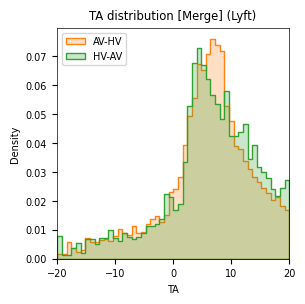

In [39]:
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
conflictType = "Merge"
histplot(
    data=conflict_df[conflict_df["Conflict type"] == conflictType],
    x="TA", 
    bins=50,
    hue="Vehicle order",
    # col="Vehicle order",
    hue_order=["AV-HV", "HV-AV"],
    common_norm=False,
    stat="density",
    palette=palette,
    multiple="layer",
    element="step",
    kde=False,
    # aspect=1.0,
    # facet_kws=dict(sharey=False)
)

plt.xlim([-20, 20])
# plt.ylim([0,0.15])
plt.legend(["AV-HV", "HV-AV"], loc="upper left")
plt.title(f"TA distribution [{conflictType}] (Lyft)")
# plt.savefig(f"./outputs/plots/waymo_distribution_TA_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()

conflict_df[conflict_df["Conflict type"] == conflictType].to_csv("lyft_ta_merge.csv")

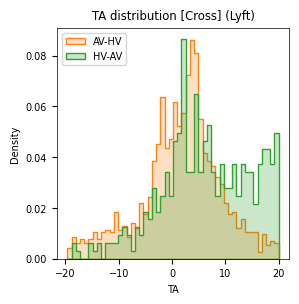

In [40]:
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3

plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
conflictType = "Cross"
histplot(
    data=conflict_df[conflict_df["Conflict type"] == conflictType],
    x="TA", 
    bins=50,
    hue="Vehicle order",
    fill=True,
    hue_order=["AV-HV", "HV-AV"],
    common_norm=False,
    stat="density",
    palette=palette,
    multiple="layer",
    element="step",
    # aspect=1.0,
    # legend=False,
    # facet_kws=dict(sharey=False)
)

# plt.xlim([0, TTC_THRESHOLD])
# plt.ylim([0,0.15])
plt.legend(["AV-HV", "HV-AV"], loc="upper left")
plt.title(f"TA distribution [{conflictType}] (Lyft)")
# plt.savefig(f"./outputs/plots/waymo_distribution_TA_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()
# conflict_df[conflict_df["Conflict type"] == conflictType].to_csv("lyft_ta_cross.csv")

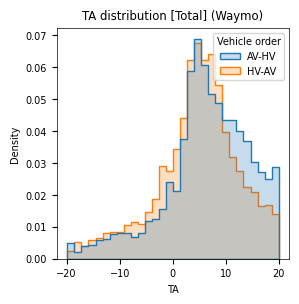

In [41]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}

HVHV_COLOR = '#257ab6'
HVAV_COLOR = '#31a231'
AVHV_COLOR = '#ff8214'

FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
conflictType = "Total"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

histplot(
    data=conflict_df,
    x="TA", 
    bins=30,
    hue="Vehicle order",
    # col="Vehicle order",
    # hue_order=["HV-HV", "AV-HV", "HV-AV"],
    common_norm=False,
    stat="density",
    # palette=palette,
    multiple="layer",
    element="step",
    # aspect=1.0,
    # legend=False,
    # facet_kws=dict(sharey=False)
)

# plt.xlim([0, TTC_THRESHOLD])
# plt.ylim([0,0.15])
# plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"TA distribution [{conflictType}] (Waymo)")
# plt.savefig(f"./outputs/plots/waymo_distribution_TA_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()